# 만들어진 Doc2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [1]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys
import os

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pandas as pd

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE

from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Embedding, embeddings, merge, Dropout, Activation,  LSTM, Bidirectional, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.utils import np_utils
import keras.backend.tensorflow_backend as K
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

Using TensorFlow backend.
/Users/hyunyoun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2772925936874913288
]


In [3]:
def Make_Roc_Curve(x, y, model1, model2, model3):
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [4]:
def plot_history(history):
    """Plot model history after `fit()`.
    """

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [5]:
import gensim
gensim.__version__

'3.3.0'

* windows에서 모델을 만들때 사용한 gensim의 버전이 3.3이었고, mac에서는 버전이 맞지 않아서 만들어둔 모델을 불러오지 못하였음.

## Doc2Vec

In [6]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [7]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [9]:
if sys.platform =='darwin':
    loadModelPath = '/Volumes/disk1/model/'
elif sys.platform =='win32':
    loadModelPath = 'd:/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

In [11]:
cores = int(multiprocessing.cpu_count() / 2)
print (cores)

2


### twitter

#### Load Model

In [12]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

#### Word to Vector

##### train set

In [ ]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_train.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_y_ct_for_sentiment_analysis'):
    train_y = [doc.tags[0] for doc in tqdm(train)]

    pickle.dump(train_y, open(saveTrainPath+'train_y_ct_for_sentiment_analysis','wb'))
    del train_y

if 'train' in locals():
    del train

##### test set

In [ ]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_test.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_y_ct_for_sentiment_analysis'):
    test_y = [doc.tags[0] for doc in tqdm(test)]

    pickle.dump(test_y, open(saveTrainPath+'test_y_ct_for_sentiment_analysis','wb'))
    del test_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [13]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [14]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [15]:
%%time
classifier = LogisticRegression(random_state=1234, n_jobs=cores)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 2, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.62
classification report
             precision    recall  f1-score   support

          0       0.68      0.56      0.61        54
          1       0.57      0.70      0.63        46

avg / total       0.63      0.62      0.62       100

CPU times: user 656 ms, sys: 74.6 ms, total: 730 ms
Wall time: 1.15 s


In [16]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [17]:
%%time
classifier2 = RandomForestClassifier(random_state=1234, n_jobs=cores)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 2, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.55
classification report
             precision    recall  f1-score   support

          0       0.57      0.67      0.62        54
          1       0.51      0.41      0.46        46

avg / total       0.54      0.55      0.54       100

CPU times: user 420 ms, sys: 21.4 ms, total: 441 ms
Wall time: 563 ms


In [18]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [19]:
%%time
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(train_x_by_m1)
train_x_by_m1_2 = scaling.transform(train_x_by_m1)
test_x_by_m1_2 = scaling.transform(test_x_by_m1)
classifier3 =  SVC(kernel = 'linear', 
        cache_size= 10000) 
classifier3.fit(train_x_by_m1_2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1_2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1_2)))

{'C': 1.0, 'cache_size': 10000, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.64
classification report
             precision    recall  f1-score   support

          0       0.70      0.57      0.63        54
          1       0.59      0.72      0.65        46

avg / total       0.65      0.64      0.64       100

CPU times: user 2.74 s, sys: 63.9 ms, total: 2.8 s
Wall time: 2.89 s


In [20]:
del scaling
del train_x_by_m1_2
del test_x_by_m1_2

In [21]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

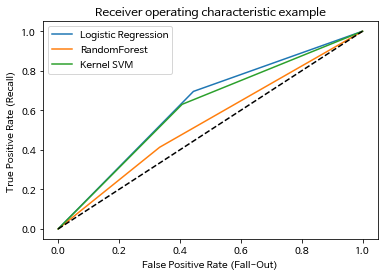

In [22]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [23]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Recurrent Neural Network

In [35]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

1000it [00:00, 396662.00it/s]
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
100it [00:00, 20316.32it/s]


In [24]:
pretrained_weights = model1.wv.syn0
vocab_size, embedding_size = pretrained_weights.shape
print ('Result embedding shape : {}'.format(pretrained_weights.shape))

Result embedding shape : (105995, 2000)


/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [38]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_size,
                   weights = [pretrained_weights]))
model.add(LSTM(units = embedding_size))
model.add(Dense(units= vocab_size))
model.add(Activation('softmax'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(train_vecs_w2v, y_train,
                    epochs=2,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback(show_inner=True)])
plot_history(history)

ValueError: Error when checking target: expected activation_2 to have shape (105995,) but got array with shape (2,)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [ ]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name

#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_ct_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_ct_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [ ]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name

#### mecab

#### Load Model

In [ ]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

#### Word to Vector

##### train set

In [ ]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_train.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name1):
    train_x_by_m1 = Get_Infer_Vector(train, model1)
    
    pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
    del train_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name2):
    train_x_by_m2 = Get_Infer_Vector(train, model2)

    pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
    del train_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'train_x_'+name3):
    train_x_by_m3 = Get_Infer_Vector(train, model3)

    pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
    del train_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'train_y_mecab_for_sentiment_analysis'):
    train_y = [doc.tags[0] for doc in tqdm(train)]

    pickle.dump(train_y, open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','wb'))
    del train_y

if 'train' in locals():
    del train

##### test set

In [ ]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_test.pickled','rb'))

In [ ]:
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name1):
    test_x_by_m1 = Get_Infer_Vector(test, model1)
    
    pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
    del test_x_by_m1
    del name1
    
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name2):
    test_x_by_m2 = Get_Infer_Vector(test, model2)

    pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
    del test_x_by_m2
    del name2

name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
if not os.path.isfile(saveTrainPath+'test_x_'+name3):
    test_x_by_m3 = Get_Infer_Vector(test, model3)

    pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
    del test_x_by_m3
    del name3

if not os.path.isfile(saveTrainPath+'test_y_mecab_for_sentiment_analysis'):
    test_y = [doc.tags[0] for doc in tqdm(test)]

    pickle.dump(test_y, open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','wb'))
    del test_y

if 'test' in locals():
    del test

#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [ ]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m1, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [ ]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m1))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m1))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m1_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [ ]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m2))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m2))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_1_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_2_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_3_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m2_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name


#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
train_x_by_m3 = pickle.load(open(saveTrainPath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_mecab_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
test_x_by_m3 = pickle.load(open(saveTrainPath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_mecab_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

#### 분류모델 : Neural Network

In [ ]:
train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test_x_by_m3))])
test_vecs_w2v = scale(test_vecs_w2v)

y_test = np_utils.to_categorical(test_y,2)
y_train = np_utils.to_categorical(train_y, 2)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=2000))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=200000, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
mode2 = Sequential()
mode2.add(Dense(64, activation='relu', input_dim=2000))
mode2.add(Dropout(0.25))
mode2.add(Dense(32, activation='relu'))
mode2.add(Dropout(0.125))
mode2.add(Dense(2, activation='softmax'))
mode2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
history = mode2.fit(train_vecs_w2v, y_train,epochs=100, batch_size=200000, verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)] )
# Evaluate model
score, acc = mode2.evaluate(test_vecs_w2v, y_test, verbose=0)

print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
train_vecs_w2v_2 = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
test_vecs_w2v_2 = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)

print (train_vecs_w2v_2.shape, test_vecs_w2v_2.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 5, kernel_size = 3,
                 activation='relu', input_shape = [2000, 1]
                ))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_vecs_w2v_2, y_train,
                    batch_size=200000,
                    epochs=100,  verbose=0, validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])
score, acc = model.evaluate(test_vecs_w2v_2, y_test, verbose=0)
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
model.save(saveClassifierPath+'NeuralNetwork_4_'+train_x_by_m3_name)

In [ ]:
plot_history(history)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name